# Agriculture Detection with PyTorch
This notebook focuses on preparing PyTorch datasets and data loaders for the satellite imagery classification task.

In [ ]:
# Import Required Libraries
import os
import importlib
import torch.nn as nn

# Local imports
import utils.main_utils as main_utils
importlib.reload(main_utils)
from utils.main_utils import (
    check_skillnetwork_extraction, 
    shuffle_data,
)
import utils.pytorch_ai_utils as pytorch_ai_utils
importlib.reload(pytorch_ai_utils)
from utils.pytorch_ai_utils import (
    create_pytorch_custom_dataset, 
    create_pytorch_dataset, 
    display_pytorch_batch, 
    set_pytorch_seed, 
    set_pytorch_processing_env,
    worker_init_fn, 
    create_pytorch_loaders,
    build_pytorch_model,
    display_pytorch_history,
    pytorch_training_loop,
    evaluate_pytorch_model
)

## Download and Extract Data
Ensure the satellite imagery dataset is available locally before constructing PyTorch datasets.

In [26]:
# Download and extract data
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar'
extract_dir = './data/'
model_dir = './models/'
os.makedirs(extract_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)
dataset_path = os.path.join(extract_dir, 'images_dataSAT')
await check_skillnetwork_extraction(extract_dir, url)

Checking write permissions for skillsnetwork extraction...
Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to 'data'


## Prepare Image Paths and Labels
Collect class-specific file paths and labels for use with PyTorch datasets.

In [27]:
# Gather image paths and labels
base_dir = './data/images_dataSAT/'
dir_non_agri_name = os.path.join(base_dir, 'class_0_non_agri')
dir_agri_name = os.path.join(base_dir, 'class_1_agri')

all_image_paths, all_labels = shuffle_data(dir_non_agri_name, dir_agri_name)

Shuffling data...


## Build PyTorch Datasets and Data Loaders
Instantiate both custom and `ImageFolder`-based datasets, then create loaders for inspection.

Creating PyTorch datasets...
Creating custom transformations for PyTorch dataset...
Classes found by ImageFolder: ['class_0_non_agri', 'class_1_agri']
Class to index mapping: {'class_0_non_agri': 0, 'class_1_agri': 1}
Creating custom transformations for PyTorch dataset...
Creating PyTorch datasets...
Creating custom transformations for PyTorch dataset...
Classes found by ImageFolder: ['class_0_non_agri', 'class_1_agri']
Class to index mapping: {'class_0_non_agri': 0, 'class_1_agri': 1}
Displaying a PyTorch data batch for Custom Loader...
Images batch shape: torch.Size([8, 3, 64, 64])
Labels batch shape: torch.Size([8])
Displaying a PyTorch data batch for ImageFolder Loader...
Images batch shape: torch.Size([8, 3, 64, 64])
Labels batch shape: torch.Size([8])


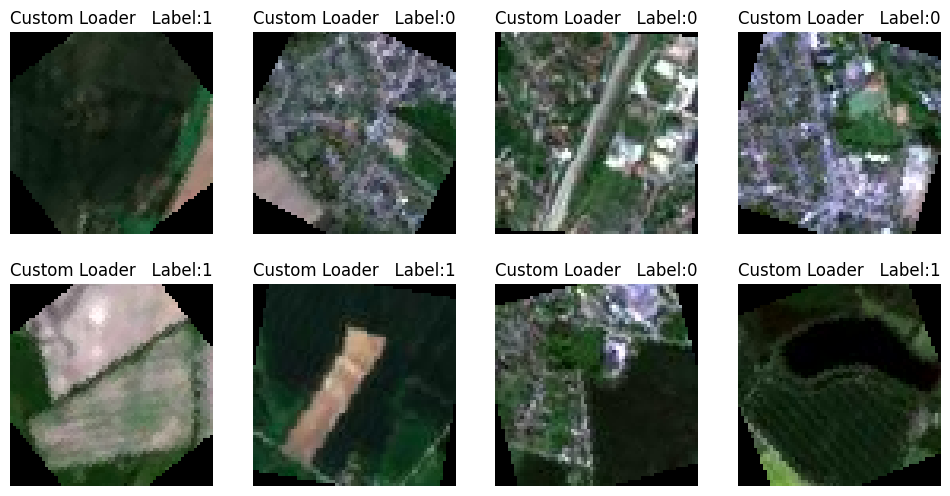

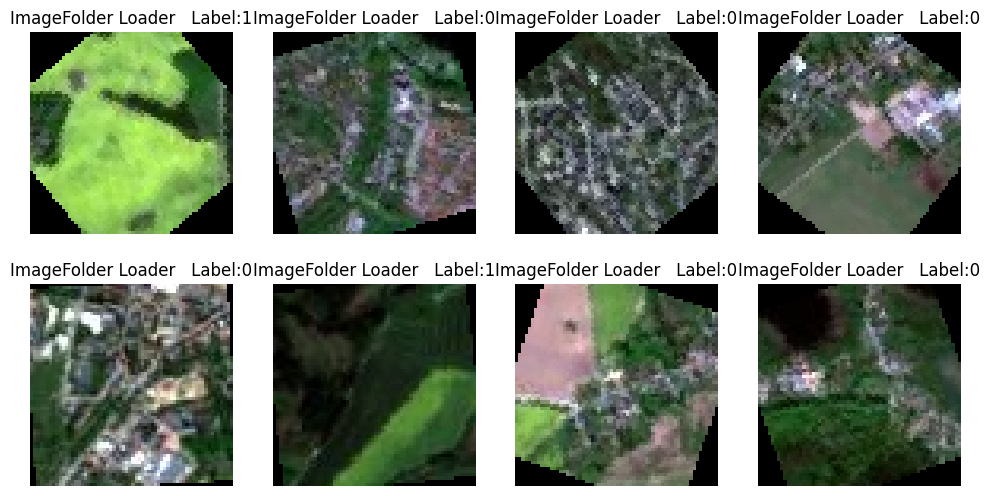

In [50]:
# Create PyTorch datasets and loaders and display batches
batch_size = 8
custom_loader = create_pytorch_custom_dataset(
    base_dir,
    dir_non_agri_name,
    dir_agri_name,
    batch_size=batch_size,
)
imagefolder_loader = create_pytorch_dataset(base_dir, batch_size=batch_size)
display_pytorch_batch(custom_loader, batch_size, title='Custom Loader')
display_pytorch_batch(imagefolder_loader, batch_size, title='ImageFolder Loader')

## Set Seed

In [32]:
SEED = 42
set_pytorch_seed(SEED)

Setting PyTorch seed to 42 for reproducibility...


## Initialize PyTorch Processing Env

In [33]:
device = set_pytorch_processing_env()

Setting PyTorch processing environment...
Device used is cpu


## Hyperparameters

In [34]:
# Data and Training Hyperparameters
img_size = 64                          # Image width and height
batch_size = 128                       # Number of samples per gradient update
lr = .001                              # Learning rate for the optimizer
epochs = 3                             # Number of times to iterate over the entire dataset
padding = 'same'                       # Padding type for convolutional layers ('same' or 0, 1, 2, ...)
loss_function = nn.CrossEntropyLoss()  # Loss function for binary classification (CrossEntropyLoss or BCEWithLogitsLoss)
num_classes = 2                        # Number of output classes (2 for CrossEntropyLoss, 1 for BCEWithLogitsLoss)
num_workers = 0                        # Number of worker processes for data loading
train_split = .8                       # Fraction of data to use for training
shuffle = True                         # Whether to shuffle the data
model_name = os.path.join(             # Name of the file to save the model
    model_dir, 
    'pytorch_model.pth'
)

# Architectural Hyperparameters
n_channels = 3                         # Number of input image channels (3 for RGB)
conv_block_num = 4                     # Number of convolutional blocks
dense_block_num = 2                    # Number of dense blocks
filter_base = 32                       # Base number of filters for convolutional layers
unit_base = 128                        # Base number of units for dense layers
kernel_size = 5                        # Kernel size for convolutional layers
pool_size = 2                          # Pool size for MaxPooling layers
dropout = 0.4                          # Dropout rate for regularization

## Create Loaders

In [35]:
train_loader, val_loader = create_pytorch_loaders(
    dataset_path=dataset_path, 
    worker=worker_init_fn,
    img_size=img_size, 
    batch_size=batch_size, 
    train_split=train_split, 
    shuffle=shuffle, 
    num_workers=num_workers
)

Creating PyTorch data loaders...


## Build PyTorch Model

In [36]:
model = build_pytorch_model(
    conv_block_num=conv_block_num,
    dense_block_num=dense_block_num,
    filter_base=filter_base,
    unit_base=unit_base,
    kernel_size=kernel_size,
    padding=padding,
    pool_size=pool_size,
    dropout=dropout,
    n_channels=n_channels,
    num_classes=num_classes, 
    device=device, 
)

Building and training PyTorch model...


## Train PyTorch Model

In [43]:
model, loss_history, acc_history = pytorch_training_loop(
    loss_function=loss_function,
    lr=lr,
    epochs=epochs, 
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader,
    device=device, 
    model_name=model_name
)

Starting PyTorch training loop...


Epoch 1/3: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Epoch 1/3
Train Loss: 0.0237 | Val Loss: 0.0441
Train Acc: 0.9931 | Val Acc: 0.9867
Epoch 1 training completed in 50.21 seconds



Epoch 2/3: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Epoch 2/3
Train Loss: 0.0161 | Val Loss: 0.0177
Train Acc: 0.9946 | Val Acc: 0.9950
Epoch 2 training completed in 43.57 seconds



Epoch 3/3: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Epoch 3/3
Train Loss: 0.0291 | Val Loss: 0.0299
Train Acc: 0.9919 | Val Acc: 0.9908
Epoch 3 training completed in 47.77 seconds



## Display Results

Displaying PyTorch training history and evaluating the model...


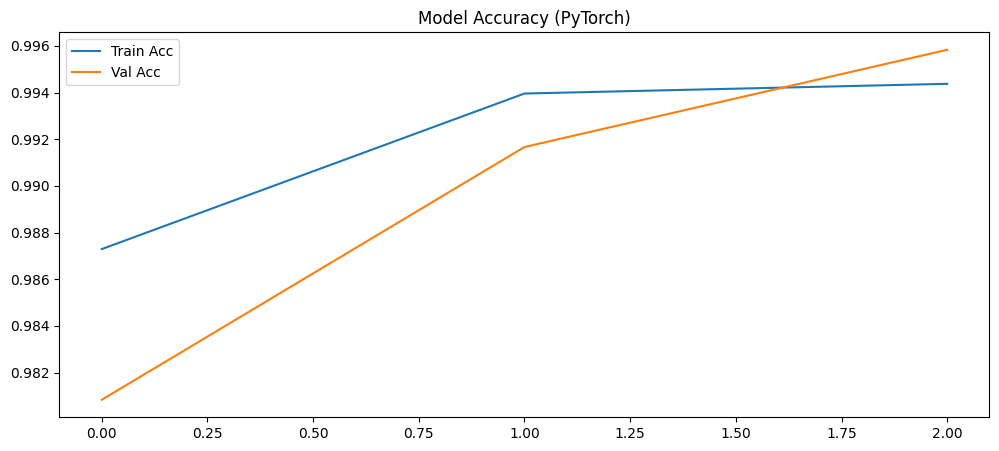

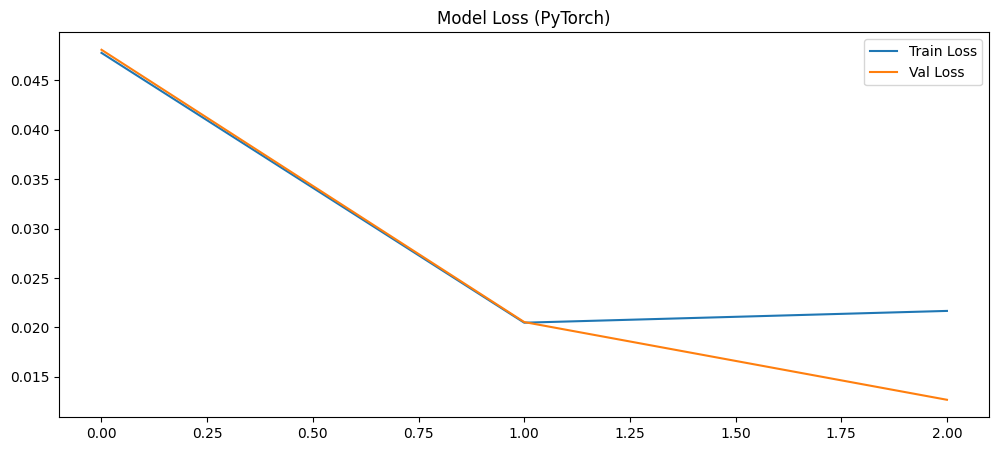

The accuracy of the model is: 0.9958


In [ ]:
display_pytorch_history(
    acc_history, 
    loss_history, 
    model, 
    val_loader, 
    device
)

## Display Metrics

Evaluating PyTorch model to display metrics...
Evaluation metrics for the ./models/pytorch_model.pth
Accuracy:  0.9908
ROC-AUC:   0.9997
Loss:      0.0288

Classification report:

                    precision    recall  f1-score   support

class_0_non_agri     0.9936    0.9888    0.9912       624
    class_1_agri     0.9879    0.9931    0.9905       576

        accuracy                         0.9908      1200
       macro avg     0.9907    0.9909    0.9908      1200
    weighted avg     0.9908    0.9908    0.9908      1200

========= Confusion Matrix =========


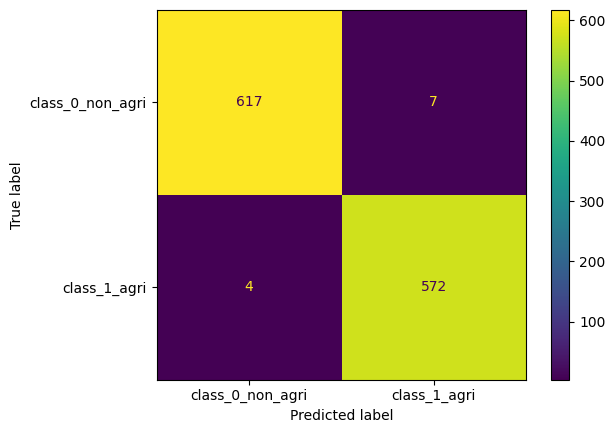

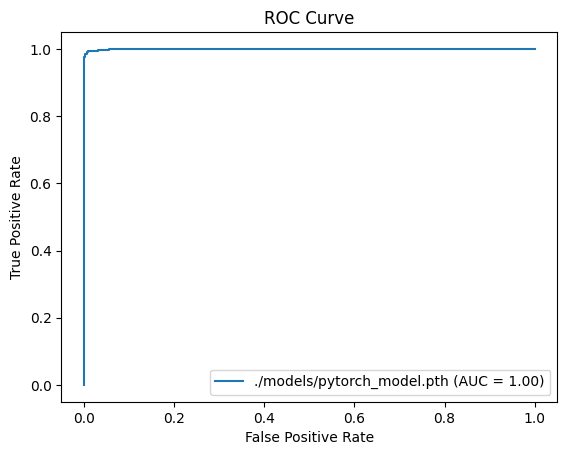

In [51]:
evaluate_pytorch_model(model, val_loader, device, model_name)